# Sentiment Analysis with Bag-of-words text representation

## Our Dataset

This dataset describes the contents of the heart-disease diagnosis.

The dataset in this study is from [Kaggle](https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment/data), which is called Twitter US Airline Sentiment.

- Dataset: https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment/data

## Variable Table

| Original Dataset             | Data Type     | Description    |                                                         
|------------------------------|---------------|---------------------------------------------------------------------------------------------|
| tweet_id                     | ID            | A unique identifier for each tweet.                                                         | 
| airline_sentiment            | Categorical   | The sentiment expressed in the tweet (positive, neutral, negative).                         | 
| airline_sentiment_confidence | Numerical     | Confidence score in the sentiment label (0 to 1).                                           | 
| negativereason               | Categorical   | Reason for negative sentiment (e.g., "Late Flight", "Customer Service Issue").              | 
| negativereason_confidence    | Numerical     | Confidence score in the negative reason label (0 to 1).                                     | 
| airline                      | Categorical   | The airline mentioned in the tweet (e.g., United, Delta, etc.).                             | 
| airline_sentiment_gold       | Categorical   | Sentiment label by trusted annotator (gold standard).                                       | 
| name                         | Text          | Name of the user who posted the tweet.                                                      | 
| negativereason_gold          | Categorical   | Negative reason label by trusted annotator (gold standard).                                 | 
| retweet_count                | Numerical     | Number of times the tweet was retweeted.                                                    | 
| text                         | Text          | The full content of the tweet.                                                              | 
| tweet_coord                  | Geospatial    | Latitude and longitude coordinates where the tweet was posted, if available.                | 
| tweet_created                | Datetime      | Timestamp when the tweet was created.                                                       | 
| tweet_location               | Text          | Location specified in the user's profile.                                                   | 
| user_timezone                | Categorical   | Time zone specified in the user's profile.                                                  | 

<br/>

# 1. Load Data

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("../../data/tweets.csv.gz", compression="gzip")

In [2]:
# Show basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [3]:
# Show the first few rows
df.head(3)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)


# 2. Data Preprocessing

## 2.1 Handle Duplicates

In [4]:
# Check for duplicate rows
duplicate_rows = df[df.duplicated()]
print(f"Number of duplicate rows: {len(duplicate_rows)}")

# Drop duplicate rows
df.drop_duplicates(inplace=True)

Number of duplicate rows: 36


In [5]:
# Confirm the shape after removal
print(f"Shape after dropping duplicates: {df.shape}")

Shape after dropping duplicates: (14604, 15)


## 2.2 Handle Missing Values

In [6]:
# Check for missing values for each variables in the dataset
print("\nMissing values count for each variables:")
print("-------------------------------------------")
print(df.isnull().sum())

print("""\n\n**Note**: We won't remove any rows with missing values here as 
our main field we use is 'text' and 'airline_sentiment' column,
which has no missing values""")


Missing values count for each variables:
-------------------------------------------
tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5445
negativereason_confidence        4101
airline                             0
airline_sentiment_gold          14564
name                                0
negativereason_gold             14572
retweet_count                       0
text                                0
tweet_coord                     13589
tweet_created                       0
tweet_location                   4723
user_timezone                    4814
dtype: int64


**Note**: We won't remove any rows with missing values here as 
our main field we use is 'text' and 'airline_sentiment' column,
which has no missing values


## 2.3 Text Processing

In [7]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\tys\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tys\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tys\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### 2.3.1 Exploratory Text Analysis for Sentiment Feature Engineering

The dataset exhibits class imbalance in the target variable 'airline_sentiment', with significantly more instances of 'negative' sentiment compared to 'neutral' and 'positive'. We will address this imbalance using the SMOTE (Synthetic Minority Over-sampling Technique).

In [8]:
df["airline_sentiment"].value_counts()

airline_sentiment
negative    9159
neutral     3091
positive    2354
Name: count, dtype: int64

This exploratory text analysis helps us identify and count irrelevant elements like URLs, mentions, and hashtags in the dataset. By removing these, we ensure that the sentiment analysis focuses on the content, not distractions.

In [9]:
from collections import Counter

url_counts = Counter(
    sum(df['text'].str.findall(r"http\S+|www\S+|https\S+"), [])
)
mention_counts = Counter(
    sum(df['text'].str.findall(r"@\w+"), [])
)
hashtag_counts = Counter(
    sum(df['text'].str.findall(r"#\w+"), [])
)

print("\n--- Summary of Elements Removed by Cleaning ---")
print(f"Total unique URLs found: {len(url_counts)}")
print(f"Most common URLs: {url_counts.most_common(5)}") # Show top 5

print(f"\nTotal unique mentions found: {len(mention_counts)}")
print(f"Most common mentions: {mention_counts.most_common(5)}") # Show top 5

print(f"\nTotal unique hashtags found: {len(hashtag_counts)}")
print(f"Most common hashtags: {hashtag_counts.most_common(5)}") # Show top 5


--- Summary of Elements Removed by Cleaning ---
Total unique URLs found: 1179
Most common URLs: [('https://t.co/F2LFULCbQ7', 4), ('http://t.co/rfXlV1kGDh', 4), ('http://t.co/3fq3XElbOn', 4), ('http://t.co/aQjn4HwNaC', 4), ('https://t.co/72RMpkOGwu', 3)]

Total unique mentions found: 928
Most common mentions: [('@united', 3765), ('@USAirways', 2907), ('@AmericanAir', 2892), ('@SouthwestAir', 2409), ('@JetBlue', 2197)]

Total unique hashtags found: 2197
Most common hashtags: [('#DestinationDragons', 75), ('#fail', 57), ('#jetblue', 35), ('#UnitedAirlines', 35), ('#customerservice', 34)]



Total unique hashtags found: 2197
Most common hashtags: [('#DestinationDragons', 75), ('#fail', 57), ('#jetblue', 35), ('#UnitedAirlines', 35), ('#customerservice', 34)]


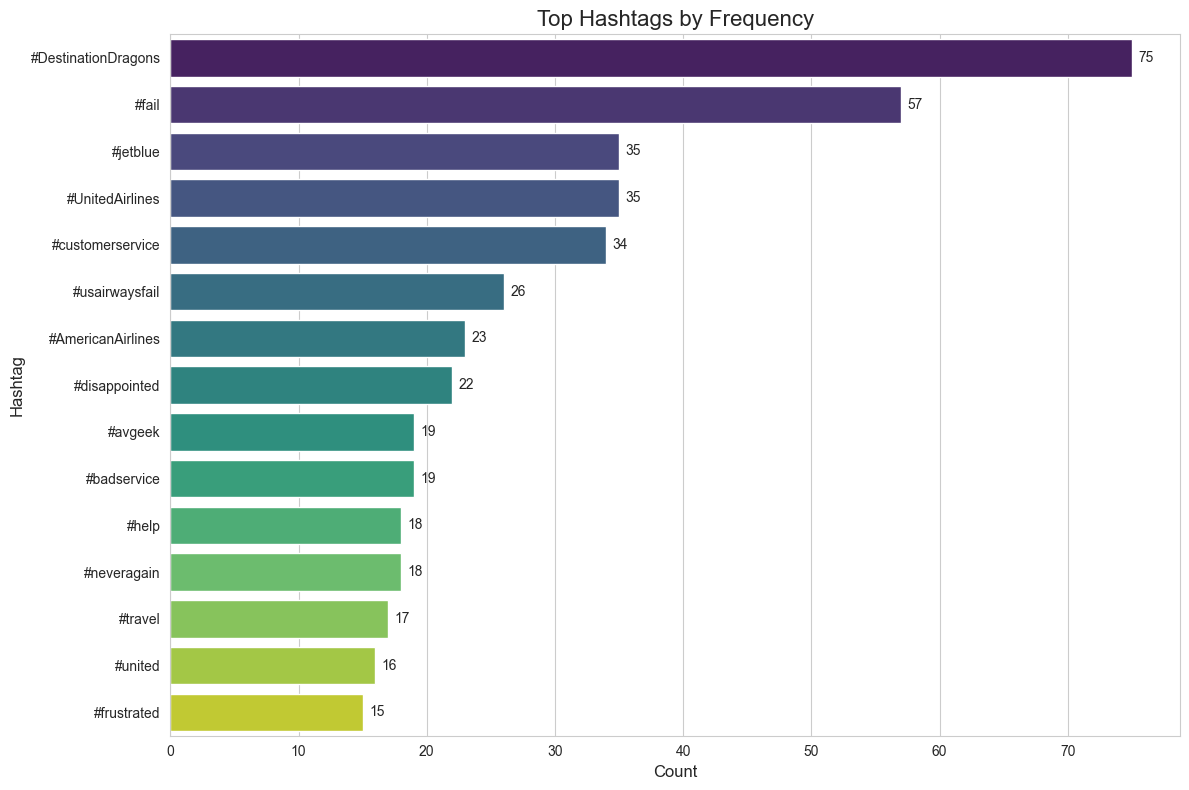

In [10]:
import re
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df is your DataFrame with a 'text' column
# First gather hashtag counts as you did
hashtag_counts = Counter(
    sum(df['text'].str.findall(r"#\w+"), [])
)

# Print summary
print(f"\nTotal unique hashtags found: {len(hashtag_counts)}")
print(f"Most common hashtags: {hashtag_counts.most_common(5)}")  # Show top 5

# Create a bar plot for the top N hashtags
def plot_top_hashtags(hashtag_counter, top_n=10):
    # Get the top N hashtags
    top_hashtags = dict(hashtag_counter.most_common(top_n))
    
    # Create a DataFrame for easier plotting
    hashtag_df = pd.DataFrame({
        'Hashtag': list(top_hashtags.keys()),
        'Count': list(top_hashtags.values())
    })
    
    # Sort by count in descending order
    hashtag_df = hashtag_df.sort_values('Count', ascending=False)
    
    # Set up the plot style
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")
    
    # Create the bar plot with updated syntax
    ax = sns.barplot(x='Count', y='Hashtag', hue='Hashtag', data=hashtag_df, palette='viridis', legend=False)
    
    # Add labels and title
    plt.title('Top Hashtags by Frequency', fontsize=16)
    plt.xlabel('Count', fontsize=12)
    plt.ylabel('Hashtag', fontsize=12)
    
    # Add count labels on the bars
    for i, v in enumerate(hashtag_df['Count']):
        ax.text(v + 0.5, i, str(v), va='center')
    
    plt.tight_layout()
    plt.show()

# Plot the top 15 hashtags
plot_top_hashtags(hashtag_counts, top_n=15)

### 2.3.2 Feature Engineering

For feature engineering in sentiment analysis, we will perform the following steps:

- `Tokenization`: Breaking the text into individual words or tokens.
- `Stopwords Removal`: Eliminating common words (e.g., "the", "is", "and") that don't contribute meaningful information.
- `Stemming`: Reducing words to their base or root form (e.g., "running" → "run", "happily" → "happy")."

In [11]:
# Initialize stopwords, stemmer
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Step 1: Lowercase and clean the text
def clean_text(text):
    text = text.lower()                                 # Lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", '', text) # Remove URLs
    text = re.sub(r'@\w+', '', text)                    # Remove mentions
    # text = re.sub(r'#\w+', '', text)                    # NOTE: Do not remove hashtags, 
                                                                # as there is a lot of hashtags with sentiment indication, 
                                                                # such as '#thankyou', '#happycustomer', etc...
    text = re.sub(r'[^a-z\s]', '', text)                # Remove numbers and punctuation
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Step 2: Tokenization
def tokenize_text(text):
    return word_tokenize(text)

# Step 3: Remove stopwords
def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words]

# Step 4: Apply Stemming
def apply_stemming(tokens):
    return " ".join([stemmer.stem(word) for word in tokens])

# Copy only the 'text' column to df_copy
df2 = df[['text', 'airline_sentiment']].copy()

# rule-based text processing for removing URL, twitter username and punctutations
df2['clean_text'] = df2['text'].apply(clean_text)

# procesed text after stemming
df2['tokens'] = df2['clean_text'].apply(tokenize_text)
df2['removed_stopwords'] = df2['tokens'].apply(remove_stopwords)
df2['stemmed'] = df2['removed_stopwords'].apply(apply_stemming)


In [12]:
df2.shape

(14604, 6)

In [13]:
# Check for missing values per column
print("\nMissing values per column:")
print(df2.isnull().sum())


Missing values per column:
text                 0
airline_sentiment    0
clean_text           0
tokens               0
removed_stopwords    0
stemmed              0
dtype: int64


### 2.3.3 Target Engineering

We will convert the 'airline_sentiment' column into numerical values to use it as the target variable in our model, where `negative` = 0, `neutral` = 1, and `positive` = 2 

In [14]:
print("The target variable contains unique values of: ", df2['airline_sentiment'].unique(), 
      "which we are going to map it into 0, 1 and 2 respectively")

# Encode the sentiment column
df2['encoded_sentiment'] = df2['airline_sentiment'].map({"negative": 0, "neutral": 1, "positive": 2})


The target variable contains unique values of:  ['neutral' 'positive' 'negative'] which we are going to map it into 0, 1 and 2 respectively


### 2.4 EDA

#### 2.4.1 Overall Sentiment distribution across six major US airlines

Total number of tweets for each airline 
  airline
United            3822
US Airways        2913
American          2723
Southwest         2420
Delta             2222
Virgin America     504
Name: airline_sentiment, dtype: int64


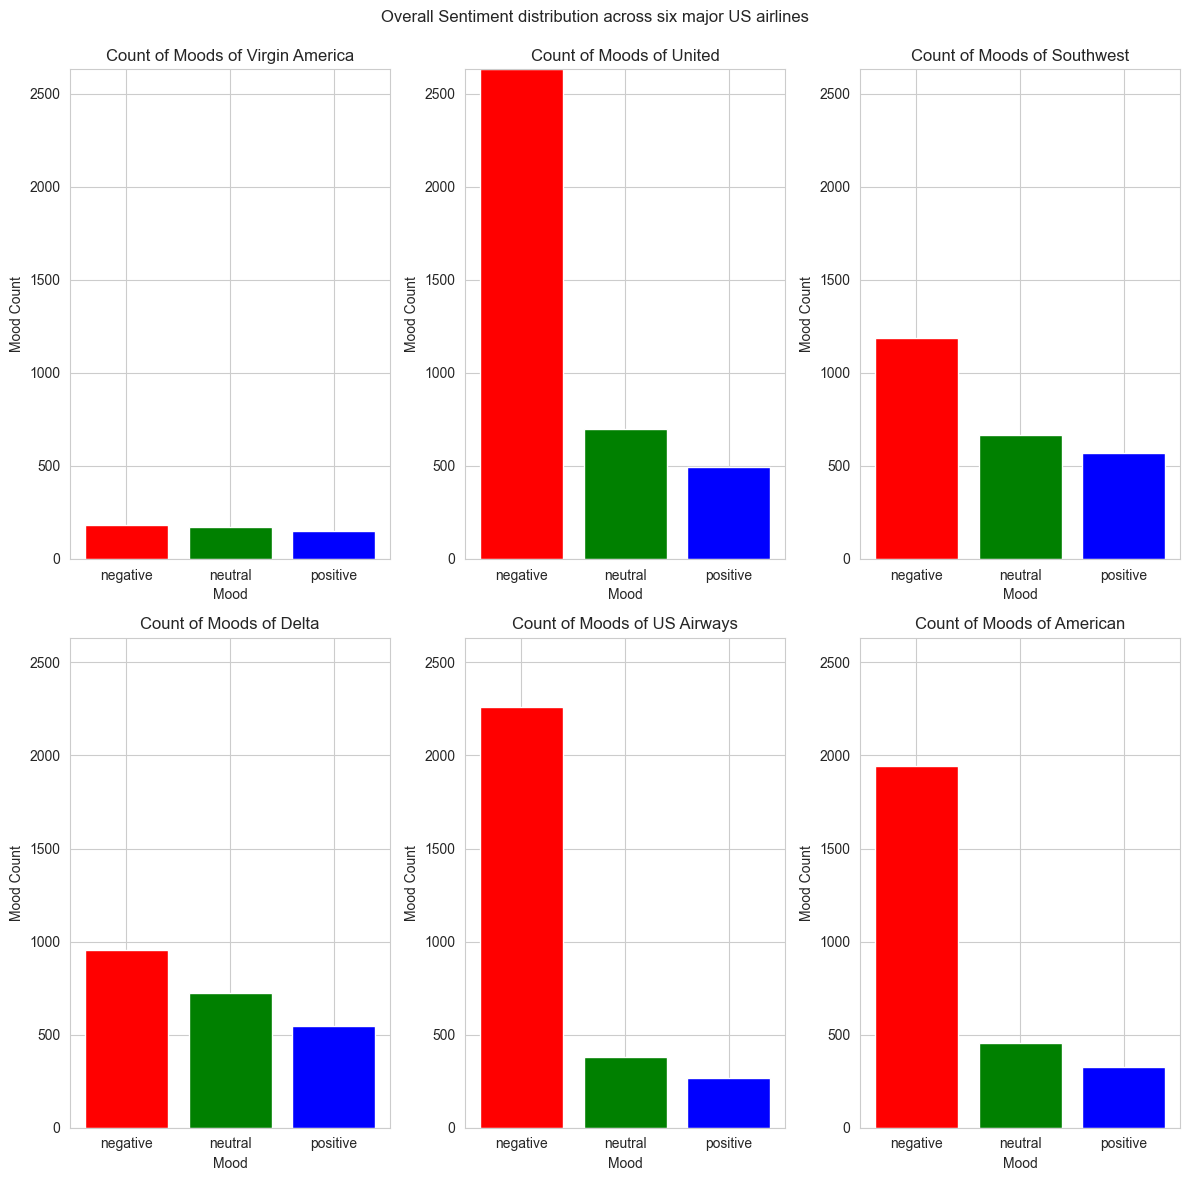

In [23]:
# Airline sentiments for each airline

print("Total number of tweets for each airline \n ",df.groupby('airline')['airline_sentiment'].count().sort_values(ascending=False))

airlines = df["airline"].unique().tolist()

# Find the maximum count across all airlines and sentiments to set uniform y-axis
max_count = 0
for airline in airlines:
    airline_df = df[df['airline'] == airline]
    current_max = airline_df['airline_sentiment'].value_counts().max()
    if current_max > max_count:
        max_count = current_max


plt.figure(1, figsize=(12, 12))
for i in airlines:
    indices = airlines.index(i)
    plt.subplot(2, 3, indices+1)
    new_df = df[df['airline'] == i]
    count = new_df['airline_sentiment'].value_counts()
    Index = [1, 2, 3]
    plt.bar(Index, count, color=['red', 'green', 'blue'])
    plt.xticks(Index, ['negative', 'neutral', 'positive'])
    plt.ylabel('Mood Count')
    plt.xlabel('Mood')
    plt.title('Count of Moods of ' + i)
    
    # Set uniform y-axis scale for all subplots
    plt.ylim(0, max_count)
    
plt.suptitle("Overall Sentiment distribution across six major US airlines\n")
plt.tight_layout()  # Add this to prevent overlap between subplots
plt.show()

#### 2.4.2 Textual Content Analysis Through Word Clouds

- Reference: https://gghantiwala.medium.com/using-wordclouds-and-n-grams-to-visualise-text-data-e71e96a3f152

In [16]:
wordcloud_df = df2.copy(deep=True)

- Word Cloud Representing Sentiments in Airline Reviews Text using Bi-grams and Tri-grams techniques, which is applied on the original 'text' column

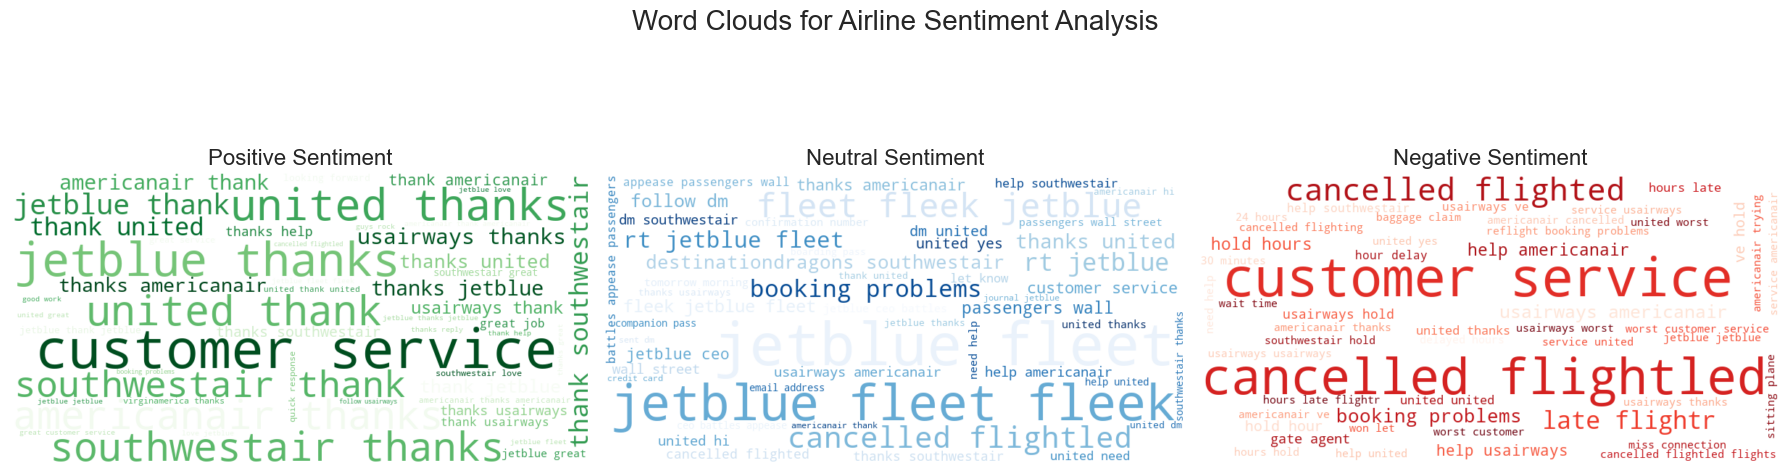

In [17]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import re

# Create figure
plt.figure(figsize=(18, 6))

# Define sentiment labels and colormap styles
sentiments = ['positive', 'neutral', 'negative']
colormaps = ['Greens', 'Blues', 'Reds']  # More distinct colors

# Enhanced stopwords list with domain-specific terms
stopwords = set(STOPWORDS)
airline_stopwords = [
    "airline", "airways", "air", "flight", "http", "https", "co", 
    "amp", "get", "got", "via", "will", "us", "one", "im", "ive", 
    "just", "now", "today", "still", "going"
]
stopwords.update(airline_stopwords)

# Minimum frequency threshold
min_freq = 3

# Helper function to clean and normalize text
def clean_text(text):
    # Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", '', text) # Remove URLs
    # Remove special characters and convert to lowercase
    text = re.sub(r'[^\w\s]', ' ', text.lower())
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Loop through each sentiment category
for i, sentiment in enumerate(sentiments):
    # Extract text from the dataframe
    text_series = wordcloud_df[wordcloud_df['airline_sentiment'] == sentiment]['text'].dropna()
    
    # Clean and combine all text
    cleaned_texts = text_series.apply(clean_text)
    combined_text = ' '.join(cleaned_texts)
    
    # Create CountVectorizer for bigrams and trigrams
    vectorizer = CountVectorizer(
        ngram_range=(2, 3), 
        stop_words='english'
    )
    
    ngram_matrix = vectorizer.fit_transform([combined_text])
    
    # Get frequencies of the ngrams
    ngram_freq = ngram_matrix.sum(axis=0).A1
    ngram_terms = vectorizer.get_feature_names_out()
    
    # Create a dictionary of ngrams and frequencies, filtering by minimum frequency
    ngram_dict = {ngram_terms[i]: ngram_freq[i] for i in range(len(ngram_terms)) if ngram_freq[i] >= min_freq}
    
    # Filter out ngrams that contain any stopwords
    filtered_ngrams = {}
    for ngram, freq in ngram_dict.items():
        if not any(word in stopwords for word in ngram.split()):
            # De-duplicate similar ngrams (removing those that are substrings of others)
            is_unique = True
            for existing_ngram in list(filtered_ngrams.keys()):
                # If this is a substring of an existing ngram with similar frequency, skip it
                if (ngram in existing_ngram or existing_ngram in ngram) and \
                   abs(ngram_dict[ngram] - filtered_ngrams.get(existing_ngram, 0)) < min_freq:
                    is_unique = False
                    # Keep the longer ngram
                    if len(ngram) > len(existing_ngram):
                        filtered_ngrams[ngram] = freq
                        del filtered_ngrams[existing_ngram]
                    break
            
            if is_unique:
                filtered_ngrams[ngram] = freq
    
    # If we have too few ngrams, adjust threshold and try again
    if len(filtered_ngrams) < 5:
        # Try with lower frequency threshold
        filtered_ngrams = {ngram_terms[i]: ngram_freq[i] for i in range(len(ngram_terms)) 
                          if ngram_freq[i] >= 1 and not any(word in stopwords for word in ngram_terms[i].split())}
        
        # If still not enough, show message
        if len(filtered_ngrams) < 5:
            plt.subplot(1, 3, i + 1)
            plt.text(0.5, 0.5, f"Not enough {sentiment} data", 
                    ha='center', va='center', fontsize=16)
            plt.axis('off')
            continue
    
    # Generate the word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=colormaps[i],
        max_words=50,  # Limit number of words
        relative_scaling=0.7,  # Scale word size more by frequency
        collocations=False  # Disable default collocation detection
    ).generate_from_frequencies(filtered_ngrams)
    
    # Plot the word cloud
    plt.subplot(1, 3, i + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'{sentiment.capitalize()} Sentiment', fontsize=16)
    plt.axis('off')

plt.suptitle("Word Clouds for Airline Sentiment Analysis", fontsize=20)
plt.tight_layout()
# plt.savefig('airline_wordcloud.png', dpi=300, bbox_inches='tight')
plt.show()

#### 2.4.3 Social Media Hashtag Sentiment Patterns

- Word Cloud Representing Sentiments in Airline Reviews Text, which is applied on the 'hashtag' column

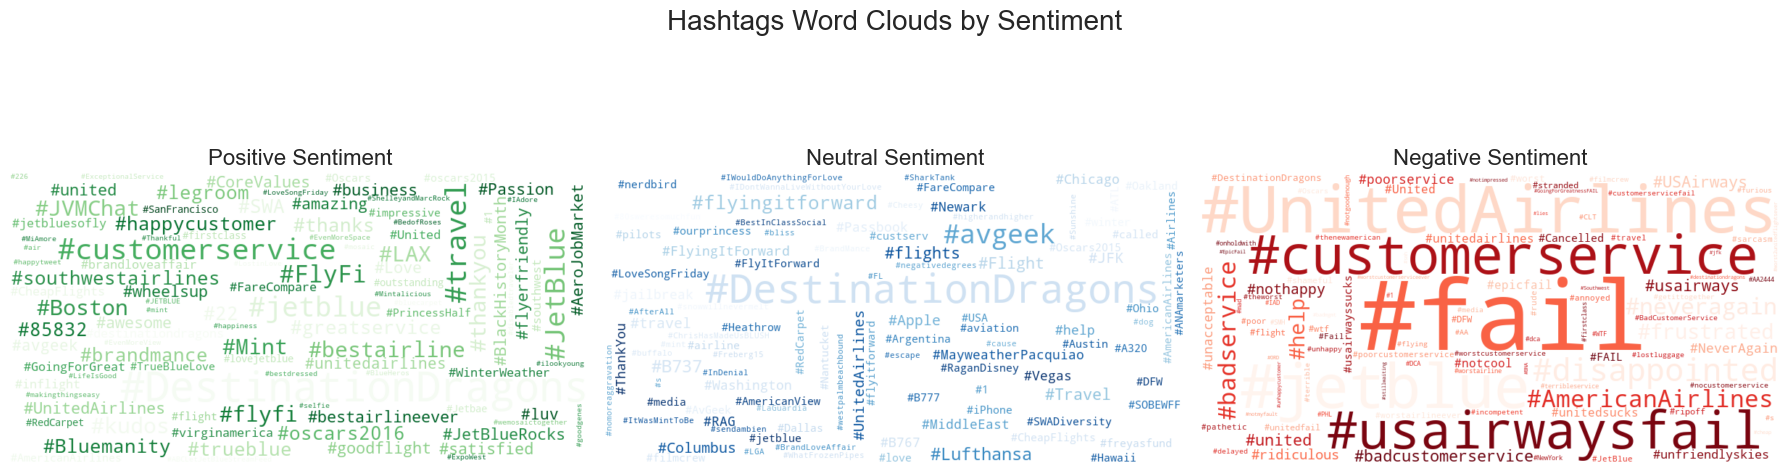

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# extract hashtag
wordcloud_df["hashtag"] = wordcloud_df["text"].str.findall(r"#\w+")

# Filter rows where there are hashtags
filtered_wordcloud_df = wordcloud_df[wordcloud_df["hashtag"].str.len() > 0]
filtered_wordcloud_df = filtered_wordcloud_df.explode(column='hashtag')
filtered_wordcloud_df[["hashtag", "airline_sentiment"]]

# Note: Do NOT convert hashtags to lowercase, as capital letters often indicate brand names (e.g., #United).
# The following line is intentionally commented out to preserve original casing:
# filtered_wordcloud_df["hashtag"] = filtered_wordcloud_df["hashtag"].str.lower()

# Define sentiment labels and colormap styles
sentiments = ['positive', 'neutral', 'negative']
colormaps = ['Greens', 'Blues', 'Reds']  # More distinct colors

# Create figure
plt.figure(figsize=(18, 6))

# Loop through each sentiment category
for i, sentiment in enumerate(sentiments):
    # Filter rows by sentiment
    sentiment_df = filtered_wordcloud_df[filtered_wordcloud_df['airline_sentiment'] == sentiment]
    
    # Count the frequency of each hashtag for the specific sentiment
    hashtag_freq = sentiment_df['hashtag'].value_counts()

    # Generate the word cloud for the sentiment
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap=colormaps[i],  # Different colormap for each sentiment
        max_words=100,  # Maximum number of words to display
        relative_scaling=0.5  # Scale word size by frequency
    ).generate_from_frequencies(hashtag_freq)

    # Plot the word cloud for this sentiment
    plt.subplot(1, 3, i + 1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'{sentiment.capitalize()} Sentiment', fontsize=16)
    plt.axis('off')

# Add overall title
plt.suptitle('Hashtags Word Clouds by Sentiment', fontsize=20)
plt.tight_layout()
plt.show()